# DTSA 5511 Introduction to Deep Learning Final Project
### Topic: Image Classification with Convolutional Neural Networks on Vehicle Dataset

## Background

In this final project, we are going to build models to classify images of vehicles. The dataset we are going to use is the [Kaggle Vehicle Dataset](https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition/data). The goal of this project is to build a CNN model that can classify images of vehicles into the correct class.

This project has the incentive to explore the application of deep learning in image classification. The dataset is relatively small, which makes it a good starting point for beginners to practice building CNN models.

Besides, upon finishing the model, it can be further developed into a vehicle recognition system that can be used in real-world applications, such as traffic monitoring, vehicle tracking, and security surveillance.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import cv2
import random
import PIL
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4
from tensorflow.keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split

import keras_tuner as kt
from keras_tuner import RandomSearch

## Exploratory Data Analysis (EDA)
### Describe the data

In [2]:
data_dir = 'Dataset'
class_names = os.listdir(data_dir)
num_classes = len(class_names)

first_class_dir = os.path.join(data_dir, class_names[0])
first_image_path = os.path.join(first_class_dir, os.listdir(first_class_dir)[0])
sample_image = cv2.imread(first_image_path)
image_height, image_width, image_channels = sample_image.shape

In [3]:
print("Class count:", num_classes)
print("height:", image_height, "width:", image_width, "channels:", image_channels)

Class count: 4
height: 400 width: 600 channels: 3


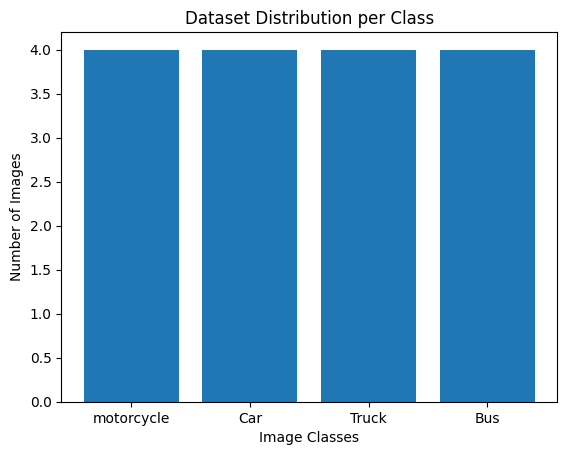

In [4]:
plt.bar(class_names, 4)
plt.xlabel('Image Classes')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution per Class')
plt.show()

Per barplot, the data is evenly distributed between the 4 classes. The data is not imbalanced.
### Image preview

In [5]:
# Function to display image samples from a dataset
def display_image_samples(data_dir, class_names, num_samples_per_class):
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        image_filenames = os.listdir(class_path)
        random.shuffle(image_filenames)
        
        fig, axs = plt.subplots(1, num_samples_per_class, figsize=(12, 4))
        
        for i in range(num_samples_per_class):
            image_path = os.path.join(class_path, image_filenames[i])
            sample_image = cv2.imread(image_path)
            sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
            
            axs[i].imshow(sample_image)
            axs[i].axis('off')
            axs[i].set_title(f'Sample {i+1}')
        
        fig.suptitle(class_name, fontsize=14, fontweight='bold')
        plt.show()

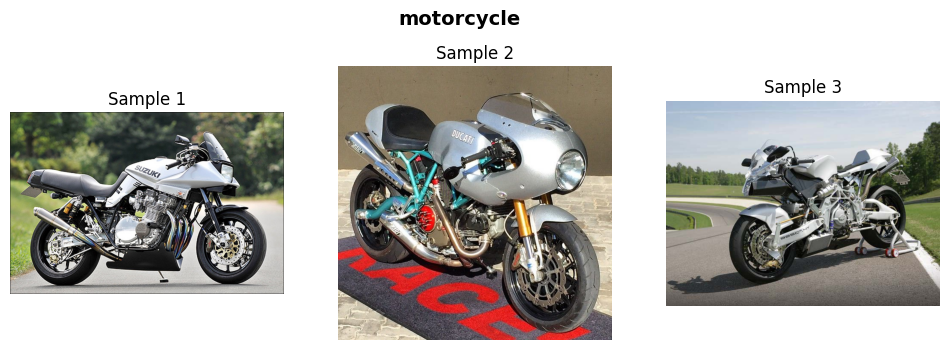

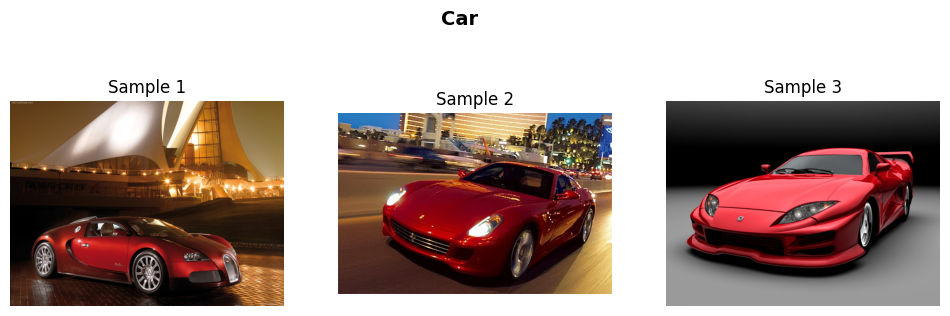

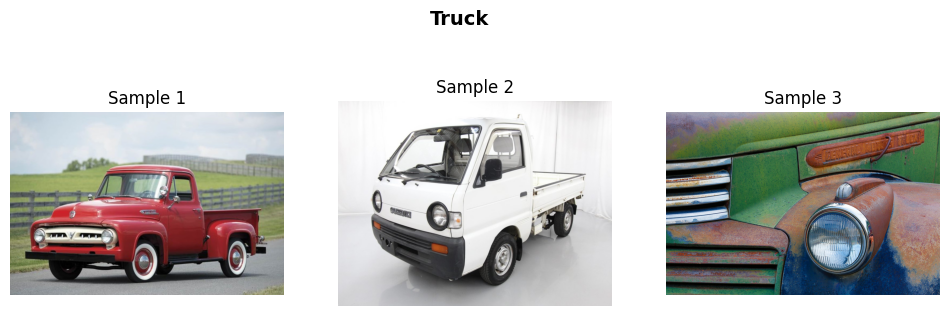

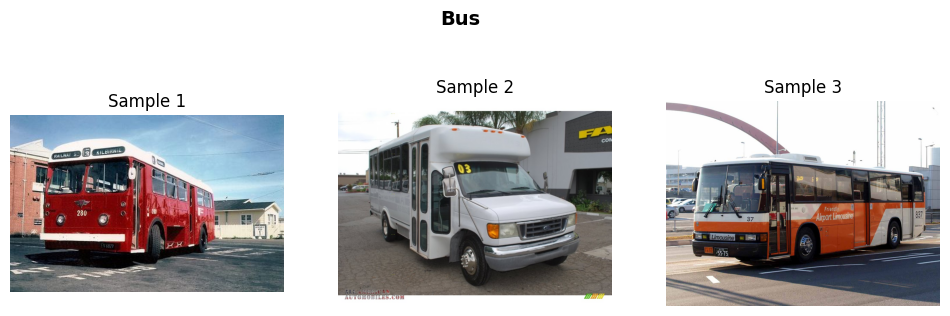

In [6]:
data_dir = 'Dataset'
num_samples_per_class = 3

class_names = os.listdir(data_dir)

display_image_samples(data_dir, class_names, num_samples_per_class)

Per inspection, images are:
- From various sources and various dimensions
- not preprocessed and are in their raw form
- not in grayscale and are in RGB format
- not normalized and are in their raw pixel values

Therefore, we are going to preprocess the images.

In [7]:
# Function to obtain image dimension statistics
def get_image_stats(data_dir, class_names):
    image_stats = []

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        image_filenames = os.listdir(class_path)

        for image_filename in image_filenames:
            image_path = os.path.join(class_path, image_filename)
            image = cv2.imread(image_path)
            image_stats.append(image.mean(axis=(0, 1)))

    image_stats = np.array(image_stats)
    mean_stats = image_stats.mean(axis=0)
    std_stats = image_stats.std(axis=0)

    print("Mean pixel values:", mean_stats)
    print("Standard deviation of pixel values:", std_stats)

In [8]:
get_image_stats(data_dir, class_names)

Mean pixel values: [114.06713775 118.03303583 123.34488098]
Standard deviation of pixel values: [41.74682924 39.56793569 40.1888138 ]


## Data Preprocessing
Resize images into a fixed dimension.

For models like ResNet-50, a common input size is 224x224 pixels. This size is a good balance between detail and computational efficiency.

Then split the data into training, validation and testing sets.

In [19]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    try:
        # Try loading with Pillow first (better at handling different formats)
        with Image.open(image_path) as img:
            # Convert to RGB, removing transparency
            if img.mode in ('RGBA', 'LA'):
                background = Image.new('RGB', img.size, (255, 255, 255))
                background.paste(img, mask=img.split()[-1])
                img = background
            
            # Convert to RGB mode
            img = img.convert('RGB')
            
            # Resize image
            img = img.resize(target_size, PIL.Image.LANCZOS)
            
            # Convert to numpy array
            img_array = np.array(img)
            
            return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def create_image_dataframe(data_dir):
    image_paths = []
    image_labels = []
    
    # Validate data directory
    if not os.path.exists(data_dir):
        raise ValueError(f"Directory {data_dir} does not exist")
    
    # Get class names, excluding hidden files/directories
    class_names = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d)) 
                   and not d.startswith('.')]
    
    num_classes = len(class_names)
    print(f"Found {num_classes} classes: {class_names}")
    
    # Collect image paths and labels
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        
        # Get image files, excluding hidden files
        image_filenames = [f for f in os.listdir(class_path) 
                           if os.path.isfile(os.path.join(class_path, f)) 
                           and not f.startswith('.')]
        
        for image_filename in image_filenames:
            image_path = os.path.join(class_path, image_filename)
            
            # Optional: Add image validation
            try:
                # Quick check if image is valid
                img = Image.open(image_path)
                img.verify()
            except Exception as e:
                print(f"Skipping invalid image: {image_path}")
                continue
            
            image_paths.append(image_path)
            image_labels.append(class_name)
    
    # Create DataFrame
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': image_labels
    })
    
    return df, class_names

def create_data_generators(df, image_size=(224, 224), batch_size=32):
    # Split the dataframe
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
    valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=42)
    
    # Create advanced data generator
    data_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,  # Use model-specific preprocessing
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant',
        cval=0,
        validation_split=0.2  # Optional: built-in validation split
    )
    
    # Create generators
    generators = {}
    for name, dataframe in [('train', train_df), ('valid', valid_df), ('test', test_df)]:
        generators[name] = data_generator.flow_from_dataframe(
            dataframe,
            directory=None,
            x_col='image_path',
            y_col='label',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=(name != 'test')
        )
    
    return generators

data_dir = 'Dataset'
image_size = (224, 224)
batch_size = 32

# Create DataFrame
df, class_names = create_image_dataframe(data_dir)

# Validate DataFrame
print(f"Total images: {len(df)}")
print(f"Class distribution:\n{df['label'].value_counts()}")

# Create generators
generators = create_data_generators(df, image_size, batch_size)

# Optional: Print class indices
print("Class Indices:", generators['train'].class_indices)
df.head()

Found 4 classes: ['motorcycle', 'Car', 'Truck', 'Bus']
Total images: 400
Class distribution:
label
motorcycle    100
Car           100
Truck         100
Bus           100
Name: count, dtype: int64
Found 320 validated image filenames belonging to 4 classes.
Found 48 validated image filenames belonging to 4 classes.
Found 32 validated image filenames belonging to 4 classes.
Class Indices: {'Bus': 0, 'Car': 1, 'Truck': 2, 'motorcycle': 3}


,image_path,label
0,Dataset/motorcycle/Image_26.jpg,motorcycle
1,Dataset/motorcycle/Image_97.JPG,motorcycle
2,Dataset/motorcycle/Image_71.jpg,motorcycle
3,Dataset/motorcycle/Image_49.jpg,motorcycle
4,Dataset/motorcycle/Image_85.jpeg,motorcycle


In [21]:
train_generator = generators['train']
valid_generator = generators['valid']
test_generator = generators['test']

In [3]:
# Create a dataframe to store image paths and corresponding labels
image_paths = []
image_labels = []

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    image_filenames = os.listdir(class_path)

    for image_filename in image_filenames:
        image_path = os.path.join(class_path, image_filename)
        image_paths.append(image_path)
        image_labels.append(class_name)
        
data = {
    'image_path': image_paths,
    'label': image_labels
}

df = pd.DataFrame(data)
df.head()
        

,image_path,label
0,Dataset/motorcycle/Image_26.jpg,motorcycle
1,Dataset/motorcycle/Image_97.JPG,motorcycle
2,Dataset/motorcycle/Image_71.jpg,motorcycle
3,Dataset/motorcycle/Image_49.jpg,motorcycle
4,Dataset/motorcycle/Image_85.jpeg,motorcycle


### Split the dataframe into training, validation and testing sets

In [4]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 420)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 420)

In [ ]:
data_dir = 'Dataset'
image_size = (224, 224)  # Desired fixed size
batch_size = 32

# Create a data generator for training images
data_generator = ImageDataGenerator(
    preprocessing_function=lambda x: x,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.4,0.6],
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True
    )

# Flow from directory with specified batch size and target image size
train_generator = data_generator.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'rgb', 
    shuffle=True
)

validation_generator = data_generator.flow_from_dataframe(
    valid_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'rgb', 
    shuffle=True
)

test_generator = data_generator.flow_from_dataframe(
    test_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'rgb', 
    shuffle=False
)

In [9]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

## Model architectures
### Homebrew CNN

We will start with a simple CNN model as baseline.

In [22]:
# Set the seed for reproducibility
np.random.seed(420)
tf.random.set_seed(1)
channels = 3

# Define the CNN model architecture
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])
cnn_model.summary()


/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

# Train the model
history = cnn_model.fit(train_generator,epochs=10,validation_data=validation_generator)
plot_training_history(history)

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 957ms/step - accuracy: 0.2327 - loss: 527.4383 - val_accuracy: 0.2083 - val_loss: 1.5388
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 652ms/step - accuracy: 0.2409 - loss: 1.5046 - val_accuracy: 0.2292 - val_loss: 1.3874
Epoch 3/10
 4/10 ━━━━━━━━━━━━━━━━━━━━ 4s 818ms/step - accuracy: 0.2064 - loss: 1.3967

KeyboardInterrupt: 

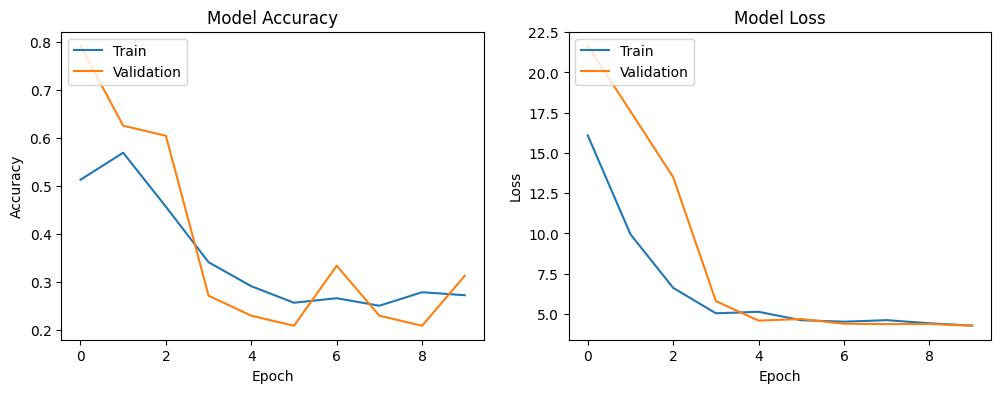

In [ ]:
plot_training_history(history)

From the plot, we can see that the model is not generalizing well to the validation set.

### CNN with increased depth
We will increase the depth of the CNN model to see if it can improve the model performance.

In [16]:
# Increased depth of CNN
cnn_model_more_depth = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])
cnn_model_more_depth.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,107,652 (19.48 MB)

 Trainable params: 5,107,652 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
cnn_model_more_depth.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

# Train the model
history = cnn_model.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 784ms/step - accuracy: 0.3530 - loss: 1.3163 - val_accuracy: 0.2292 - val_loss: 1.3927
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 655ms/step - accuracy: 0.3139 - loss: 1.3483 - val_accuracy: 0.2708 - val_loss: 1.3702
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.3127 - loss: 1.3710 - val_accuracy: 0.3125 - val_loss: 1.3564
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 682ms/step - accuracy: 0.3335 - loss: 1.3275 - val_accuracy: 0.3750 - val_loss: 1.3082
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 653ms/step - accuracy: 0.2792 - loss: 1.3808 - val_accuracy: 0.3125 - val_loss: 1.3285
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 703ms/step - accuracy: 0.3262 - loss: 1.3500 - val_accuracy: 0.3542 - val_loss: 1.3288
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 755ms/step - accuracy: 0.3040 - loss: 1.3462 - val_accuracy: 0.2708 - val_loss: 1.3394
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 869ms/step - accuracy: 0.2717 - loss: 1.3385 - val_accuracy: 0.

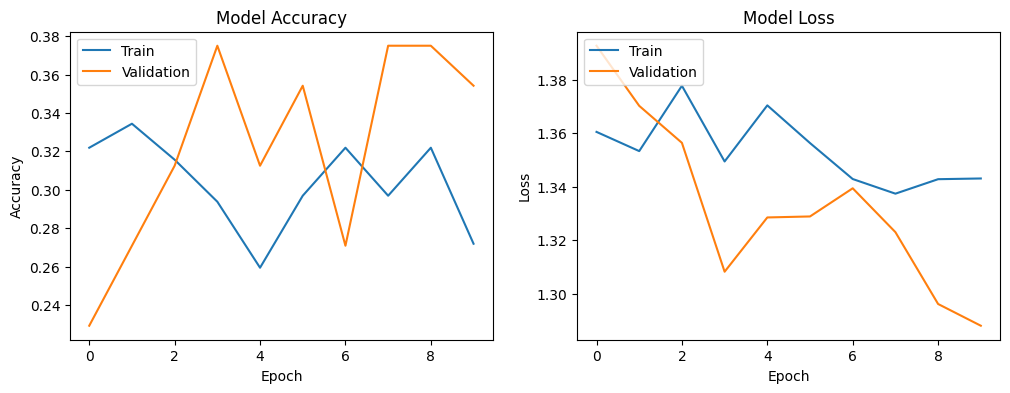

In [18]:
plot_training_history(history)

Not much improvement in the model performance. The model is still overfitting.

### CNN Model with Batch Normalization
We will add batch normalization to the CNN model to see if it can improve the model performance.

In [19]:
cnn_model_normalized = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, channels)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])

# Compile and train the model
cnn_model_normalized.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = cnn_model_normalized.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2383 - loss: 16.6604 - val_accuracy: 0.2083 - val_loss: 79.5524
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2811 - loss: 8.6144 - val_accuracy: 0.2917 - val_loss: 14.2521
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2765 - loss: 3.2131 - val_accuracy: 0.2083 - val_loss: 2.2594
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2757 - loss: 2.0406 - val_accuracy: 0.3125 - val_loss: 1.3783
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2721 - loss: 1.4902 - val_accuracy: 0.2500 - val_loss: 2.2230
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 983ms/step - accuracy: 0.2775 - loss: 1.5055 - val_accuracy: 0.2083 - val_loss: 1.4882
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2593 - loss: 1.4234 - val_accuracy: 0.2083 - val_loss: 1.3941
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3360 - loss: 1.4876 - val_accuracy: 0.1667 - val

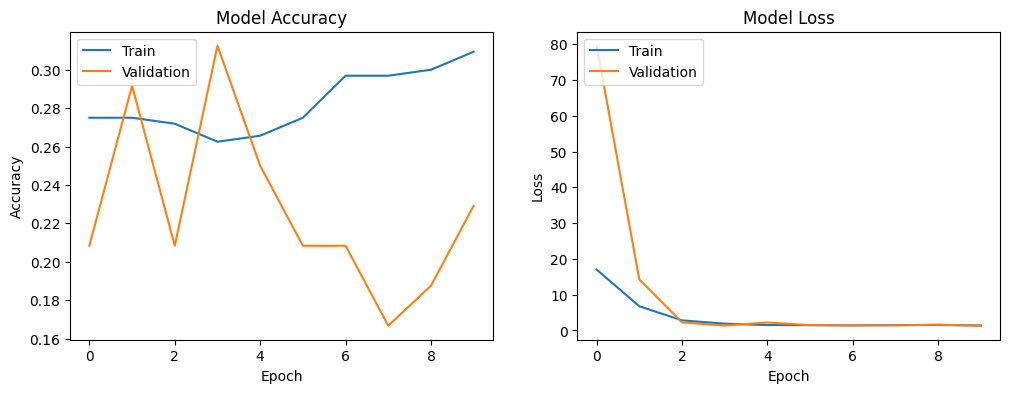

In [20]:
plot_training_history(history)

The model is still overfitting. The model is not generalizing well to the validation set.

The possible reason that our homebrew CNN is not performing well is that the dataset is relatively small. The model is too complex for the small dataset, which leads to overfitting. We will try to use a pre-trained model to see if it can improve the model performance.

## Pre-trained model
Below I have chosen a couple of pre-trained models to use for transfer learning. I will use the pre-trained models to extract features from the images and then use these features to train a classifier.

Advantages of using pre-trained models:
- Pre-trained models have already been trained on large datasets and have learned features that are useful for a wide range of tasks.
- Using pre-trained models can save time and computational resources.

Therefore, I will experiment with different pre-trained models to see which one works best for this task.

1. ResNet50
2. EfficentNet
2. MobileNetV2

### ResNet50

In [24]:
# Load the ResNet50 model with pre-trained weights, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, channels))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the final model
resnet_model = Model(inputs=base_model.input, outputs=predictions)
resnet_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 24,585,732 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [25]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model and store the training history
history = resnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Call the function to plot the training history
plot_training_history(history)

Epoch 1/10


2025-03-01 19:03:47.221940: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4989_0', 112 bytes spill stores, 224 bytes spill loads

2025-03-01 19:03:47.382637: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4989', 220 bytes spill stores, 576 bytes spill loads

2025-03-01 19:03:48.872605: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5209', 24 bytes spill stores, 24 bytes spill loads

2025-03-01 19:03:49.046150: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5209', 60 bytes spill stores, 64 bytes spill loads

2025-03-01 19:03:49.270728: I external/local_xla/xla/s

10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4964 - loss: 1.9072 - val_accuracy: 0.6667 - val_loss: 1.1312
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 691ms/step - accuracy: 0.7647 - loss: 0.6643 - val_accuracy: 0.7500 - val_loss: 0.6410
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - accuracy: 0.8951 - loss: 0.2131 - val_accuracy: 0.7708 - val_loss: 0.5444
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 640ms/step - accuracy: 0.9480 - loss: 0.1005 - val_accuracy: 0.7500 - val_loss: 0.4034
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 685ms/step - accuracy: 0.9642 - loss: 0.0977 - val_accuracy: 0.8542 - val_loss: 0.2776
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 750ms/step - accuracy: 0.9683 - loss: 0.0845 - val_accuracy: 0.8333 - val_loss: 0.4426
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 663ms/step - accuracy: 0.9545 - loss: 0.1052 - val_accuracy: 0.8333 - val_loss: 0.5897
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 687ms/step - accuracy: 0.9716 - loss: 0.0728 - val_accuracy: 0.6042 - val_lo

: 

Per inspection, the model accuracy for validation is at highest of 0.854 and the model loss is at lowest of 0.277. It shows a significant improvement compared to the homebrew CNN model. The model is not overfitting and is generalizing well to the validation set.

In [1]:
# Recompile the model with a low learning rate
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.00009), 
    metrics=['accuracy']
    )

# Train the model and store the training history
history = resnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Call the function to plot the training history
plot_training_history(history)

NameError: name 'resnet_model' is not defined

This model with lowest learning rate shows much higher training accuracy and lower training model loss. However, these statistics for validation set is similar to the model with higher learning rate. We will proceed to test further with testing set later. 

### Hyperparameter tuning

In [24]:
# def build_model(hp):
#     # Load the base ResNet50 model
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, channels))
    
#     # Tune the number of dense layers
#     num_dense_layers = hp.Int('num_dense_layers', 1, 3)
    
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
    
#     # Dynamically add dense layers with tunable units and activation
#     for i in range(num_dense_layers):
#         x = Dense(
#             units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
#             activation=hp.Choice(f'activation_{i}', ['relu', 'tanh'])
#         )(x)
    
#     # Final output layer
#     predictions = Dense(len(class_names), activation='softmax')(x)
    
#     # Create model
#     model = Model(inputs=base_model.input, outputs=predictions)
    
#     # Tune learning rate
#     learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
#     # Compile model with tuned optimizer and learning rate
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
    
#     return model

# # Create the tuner
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=50,
#     factor=3,
#     directory='hyperparameter_tuning',
#     project_name='vehicle_recognition'
# )

# # Perform hyperparameter search
# tuner.search(
#     train_generator,
#     epochs=50,
#     validation_data=validation_generator,
#     callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy')]
# )

# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Print the optimal hyperparameters
# print("Optimal Hyperparameters:")
# print(f"Number of Dense Layers: {best_hps.get('num_dense_layers')}")
# print(f"Learning Rate: {best_hps.get('learning_rate')}")

# # Retrieve the best model
# best_model = tuner.get_best_models(num_models=1)[0]

# # Retrain the best model with full training data
# final_history = best_model.fit(
#     train_generator,
#     epochs=50,
#     validation_data=validation_generator
# )


### EfficientNet
The EfficientNet model is used for transfer learning. The model is trained on the ImageNet dataset and has been shown to achieve state-of-the-art performance on a wide range of tasks.

We are testing with both B0 and B4 model.

In [8]:
base_model = EfficientNetB0(
    include_top=False, 
    weights="imagenet", 
    input_shape=(224, 224, 3), 
    pooling='max'
)

# Model architecture with advanced regularization
efficientnet_model = Sequential([
    base_model,
    BatchNormalization(
        axis=-1, 
        momentum=0.99, 
        epsilon=0.001
    ),
    Dense(
        128, 
        kernel_regularizer=l2(0.016), 
        activity_regularizer=l1(0.006),
        bias_regularizer=l1(0.006), 
        activation='relu'
    ),
    Dropout(
        rate=0.45, 
        seed=123
    ),
    Dense(
        4, 
        activation='softmax'
    )
])
efficientnet_model.summary()

I0000 00:00:1740823208.324855   30670 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,219,175 (16.09 MB)

 Trainable params: 4,174,592 (15.92 MB)

 Non-trainable params: 44,583 (174.16 KB)

Epoch 1/10
 5/10 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 0.2009 - loss: 4.0745

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.2105 - loss: 3.9389 - val_accuracy: 0.2917 - val_loss: 3.3540
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 645ms/step - accuracy: 0.2569 - loss: 3.1074 - val_accuracy: 0.2917 - val_loss: 3.4322
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 660ms/step - accuracy: 0.1879 - loss: 2.7398 - val_accuracy: 0.2292 - val_loss: 4.0337
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.2217 - loss: 2.5705 - val_accuracy: 0.2083 - val_loss: 2.8391
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 652ms/step - accuracy: 0.2199 - loss: 2.5092 - val_accuracy: 0.2708 - val_loss: 2.4786
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 720ms/step - accuracy: 0.2836 - loss: 2.4237 - val_accuracy: 0.2292 - val_loss: 2.3529
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 670ms/step - accuracy: 0.2757 - loss: 2.3360 - val_accuracy: 0.2083 - val_loss: 2.2500
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 666ms/step - accuracy: 0.2663 - loss: 2.2584 - val_accuracy: 0.2917 - val_lo

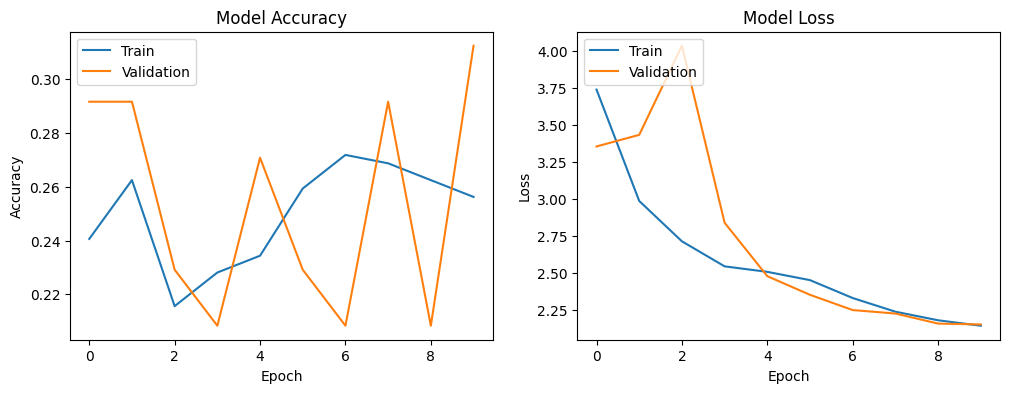

: 

In [ ]:
efficientnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = efficientnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    batch_size=32
)
plot_training_history(history)

### EfficientNet B4

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1792)           │         7,168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,911,011 (68.33 MB)

 Trainable params: 17,782,220 (67.83 MB)

 Non-trainable params: 128,791 (503.09 KB)

Epoch 1/10


I0000 00:00:1740825068.180731    4119 service.cc:148] XLA service 0x7f7b04002040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740825068.181591    4119 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-01 18:31:09.742058: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740825075.944273    4119 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1740825138.533066    4119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 4/10 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.3639 - loss: 18.9946

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.4314 - loss: 18.1885 - val_accuracy: 0.6250 - val_loss: 18.7786
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 766ms/step - accuracy: 0.5522 - loss: 12.6345 - val_accuracy: 0.7083 - val_loss: 16.2671
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 688ms/step - accuracy: 0.6162 - loss: 6.8408 - val_accuracy: 0.6667 - val_loss: 15.4719
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 811ms/step - accuracy: 0.5599 - loss: 5.3103 - val_accuracy: 0.6875 - val_loss: 9.9195
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5033 - loss: 4.8526 - val_accuracy: 0.5208 - val_loss: 9.3562
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 743ms/step - accuracy: 0.3037 - loss: 4.6745 - val_accuracy: 0.5000 - val_loss: 6.6909
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 648ms/step - accuracy: 0.3021 - loss: 4.5683 - val_accuracy: 0.3542 - val_loss: 6.4623
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 689ms/step - accuracy: 0.2877 - loss: 4.5052 - val_accuracy: 0.3958 - va

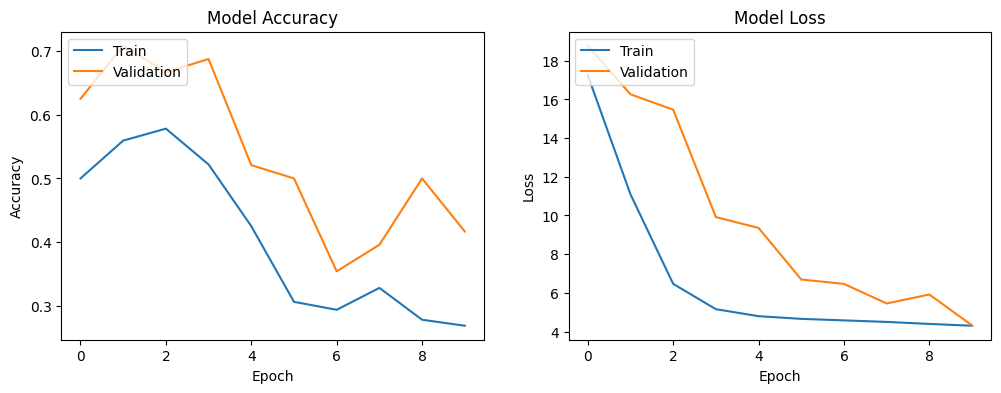

In [10]:
base_model = EfficientNetB4(
    include_top=False, 
    weights="imagenet", 
    input_shape=(224, 224, 3), 
    pooling='max'
)

# Model architecture with advanced regularization
efficientnet_model = Sequential([
    base_model,
    BatchNormalization(
        axis=-1, 
        momentum=0.99, 
        epsilon=0.001
    ),
    Dense(
        128, 
        kernel_regularizer=l2(0.016), 
        activity_regularizer=l1(0.006),
        bias_regularizer=l1(0.006), 
        activation='relu'
    ),
    Dropout(
        rate=0.45, 
        seed=123
    ),
    Dense(
        4, 
        activation='softmax'
    )
])
efficientnet_model.summary()

efficientnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = efficientnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    batch_size=32
)
plot_training_history(history)

From result, there is no siginificant improvement in the model performance compared to the efficientnet B0 model.

### Attempt on EfficientnetB7
Per claimed by [this article](https://sahilchachra.medium.com/comparative-study-using-efficientnetb0-to-efficientnetb7-as-encoder-in-unet-a73ec6aeffe8), EfficientnetB7 is the best model among the Efficientnet series. 

However it requires a lot of computational resources and time to train, and my computer is not able to handle it.

### MobileNet
 MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks. We will use the MobileNetV2 model for transfer learning.

In [ ]:
# Create MobileNet model

mobile_net_model = MobileNetV2(
    include_top=False, 
    weights="imagenet", 
    input_shape=(224, 224, 3), 
    pooling='max'
)

for layer in mobile_net_model.layers:
    layer.trainable = False
    
# Model architecture with advanced regularization

mobile_net_model = Sequential([
    mobile_net_model,
    BatchNormalization(
        axis=-1, 
        momentum=0.99, 
        epsilon=0.001
    ),
    Dense(
        128, 
        kernel_regularizer=l2(0.016), 
        activity_regularizer=l1(0.006),
        bias_regularizer=l1(0.006), 
        activation='relu'
    ),
    Dropout(
        rate=0.45, 
        seed=123
    ),
    Dense(
        4, 
        activation='softmax'
    )
])

mobile_net_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
mobile_net_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = mobile_net_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    batch_size=32
)
plot_training_history(history)

Epoch 1/10
 4/10 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.2402 - loss: nan

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2432 - loss: nan - val_accuracy: 0.2917 - val_loss: 7.4414
Epoch 2/10
 6/10 ━━━━━━━━━━━━━━━━━━━━ 2s 619ms/step - accuracy: 0.2604 - loss: 8.5517

KeyboardInterrupt: 